# Check cleaned eeg data 

In [1]:
import itertools
import PyQt5
import numpy as np
import os
import pyxdf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import mne
import json
import glob
import re
import scipy
from scipy import signal
import importlib
import multiprocessing as mp
import sys
from mne.time_frequency import tfr_morlet
# from utils.read_data import *

#from mne.preprocessing import ASR


In [2]:
DATA_PATH = './raw_data/'
PROCESSED_PATH = './processed_data/'

montagefile = "./ANT_EEG_channel_mapping.json"

os.makedirs(PROCESSED_PATH,  exist_ok=True)

## Create trial info df 

In [3]:
trial_info = pd.read_csv(f'{PROCESSED_PATH}/trial_conditions.csv')

trial_info['raw_data_file'] = (
    DATA_PATH 
    + trial_info['subject_id'].astype(str) + '/' 
    + trial_info['subject_id'].astype(str) + '_' 
    + trial_info['block_id'].astype(str)
    + '.xdf'
)



def find_preprocessed_files(subject_id='', block_id='', save_dir=''):
#     D:\projects\GTI_decoding\code\paper\processed_data\M009\4\eeg\04_cleaned\block_4_eeg.fif
    clean_fname = glob.glob(os.path.join(save_dir,subject_id, str(block_id),"eeg/04_cleaned/*_eeg.fif"))
    epoched_fname = glob.glob(os.path.join(save_dir,subject_id, str(block_id),"eeg/03_epoched/*_epo.fif"))
    raw_epo_fname = glob.glob(os.path.join(save_dir,subject_id, str(block_id),"eeg/05_rawepochs/*_epo.fif"))
    
    if len(clean_fname)==0 or len(epoched_fname) == 0 or len(raw_epo_fname) == 0:
        return ['', '', '']
    
    return [clean_fname[0], epoched_fname[0], raw_epo_fname[0]]

for idx, row in trial_info.iterrows():
    trial_info.loc[idx, ['cleaned_data', 'epoched_data', 'raw_epochs']] = (
        find_preprocessed_files
        (row['subject_id'], 
         row['block_id'], 
         './processed_data/'
        )
    )
    
trial_info = trial_info.query('epoched_data !=""')

trial_info.trial_id = trial_info.trial_id - 1
trial_info.trial_id = trial_info.groupby('subject_id').trial_id.cumcount()

trial_info.shape

(6672, 14)

In [4]:
trial_info.head()

,Unnamed: 0,subject_id,block_id,trial_id,familiarity,task,orientation,tool_name,time,condition,raw_data_file,cleaned_data,epoched_data,raw_epochs
0,0,M006,1,0,unfam,use,right,fishscaler,732,unfam/use/right,./raw_data/M006/M006_1.xdf,./processed_data/M006\1\eeg/04_cleaned\block_1...,./processed_data/M006\1\eeg/03_epoched\block_1...,./processed_data/M006\1\eeg/05_rawepochs\block...
1,1,M006,1,1,fam,use,right,paintbrush,732,fam/use/right,./raw_data/M006/M006_1.xdf,./processed_data/M006\1\eeg/04_cleaned\block_1...,./processed_data/M006\1\eeg/03_epoched\block_1...,./processed_data/M006\1\eeg/05_rawepochs\block...
2,2,M006,1,2,fam,use,right,fork,732,fam/use/right,./raw_data/M006/M006_1.xdf,./processed_data/M006\1\eeg/04_cleaned\block_1...,./processed_data/M006\1\eeg/03_epoched\block_1...,./processed_data/M006\1\eeg/05_rawepochs\block...
3,3,M006,1,3,fam,lift,right,spatula,732,fam/lift/right,./raw_data/M006/M006_1.xdf,./processed_data/M006\1\eeg/04_cleaned\block_1...,./processed_data/M006\1\eeg/03_epoched\block_1...,./processed_data/M006\1\eeg/05_rawepochs\block...
4,4,M006,1,4,unfam,use,left,fishscaler,732,unfam/use/left,./raw_data/M006/M006_1.xdf,./processed_data/M006\1\eeg/04_cleaned\block_1...,./processed_data/M006\1\eeg/03_epoched\block_1...,./processed_data/M006\1\eeg/05_rawepochs\block...


## Concatenate all blocks per subject

In [7]:
epochs_list=[]
PROCESSED_PATH = './processed_data/'
for subject in trial_info.query('subject_id =="M006"').subject_id.unique():
    epochs_list=[]
    for ep in trial_info.query('subject_id=="M006" and block_id in [1, 2]').epoched_data.unique():
        try:
            print(f"*********{ep}***********")
            epochs_list.append(mne.read_epochs(ep, verbose=False))
            clean_epochs = mne.concatenate_epochs(epochs_list)
            clean_epochs.drop_channels(['Cz'])
            save_dir = f'{PROCESSED_PATH}/{subject}/epoched/'
            os.makedirs(save_dir, exist_ok=True)
            clean_epochs.save(os.path.join(save_dir, 'all_trials_epo.fif'), overwrite=True)
        except Exception as e:
            print(ep, '\n\n', e)
            continue
        
        

*********./processed_data/M006\1\eeg/03_epoched\block_1_epo.fif***********
Not setting metadata
48 matching events found
No baseline correction applied
Overwriting existing file.
Overwriting existing file.
*********./processed_data/M006\2\eeg/03_epoched\block_2_epo.fif***********
Not setting metadata
96 matching events found
No baseline correction applied
Overwriting existing file.
Overwriting existing file.


## Band pass filter each epoch and perform GED

In [268]:
def covmat(X):
    """Takes a channels-by-time matrix and returns a channels-by-channels covariance matrix."""
    C = []
    for i in range(X.shape[0]):
        C.append((X[i] @ X[i].T) / X[i].shape[1])
        
    # C = np.array(C).mean(axis=0)
    return C

def remove_outliers(C):
    """Takes a matrix with dimensions trial x channel x channel and returns the z-scored Euclidean distances to the mean"""
    C = np.array(C)
    # print('shape of input array:', C.shape)
    # mean covariance matrix
    C_mean = np.mean(C, axis = 0)

    # initialize vector of length of trials
    dists = np.zeros(C.shape[0])

    # loop over trials and compute the Euclidean distance to the mean
    for i in range(C.shape[0]):
        
        dists[i] = np.sqrt(np.sum((C[i].reshape(1, -1) - C_mean.reshape(1, -1))**2))

    # transform to z-scored distances
    z = (dists - np.mean(dists)) / np.std(dists)

    # print('shape of z:', z.shape)

    C = C[z<=3]

    # print('shape of input after outlier:', C.shape)

    return np.mean(C, axis = 0)


def ged(covS, covR, normalize_vector=True):
    """Takes two symmetric matrices and returns the (normalized) Eigenpairs sorted in ascending order."""
    # Apply 1% shrinkage regularization to improve separability
    g = 0.01;
    # covRr = (1-g)*covR + g*np.mean(scipy.linalg.eigh(covR))*np.eye(covR.shape[1])
    # compute the Eigenpairs (order of params in the function call matters!)
    # np.array(C)/X.shape[0]
    try:
    # print('is covS positive definite? ', np.all(np.linalg.eigvals(covS) > 0))
    # print('is covR positive definite? ', np.all(np.linalg.eigvals(covR) > 0))
    
        evals, evecs = scipy.linalg.eigh(covS, covR)
    
        # sort from the largest to smallest Eigenvalue
        idx  = evals.argsort()[::-1]
        evals = evals[idx]
        evecs = evecs[:, idx]
        
    except Exception as e:
        return [0], 0

    if normalize_vector:
        # multiply each Eigenvector in the Eigenvector matrix with the inverse of its length
        # -> Eigenvector has unit length
        for i in range(np.size(evecs, axis = 1)):
            evecs[:, i] = (1/scipy.linalg.norm(evecs[:, i]))*evecs[:, i]

    return np.round(evecs[0], 3), np.round(evals[0], 3)

def vector_to_diagonal_matrix(vector):
    """Takes a vector and returns a diagonal matrix."""

    diag_matrix = np.zeros((len(vector), len(vector)))

    for i in range(len(vector)):
        diag_matrix[i, i] = vector[i]

    return diag_matrix



In [249]:
epochs.info

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,67 points
Good channels,63 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,2.00 Hz
Lowpass,50.00 Hz


In [269]:
GED_freq = pd.DataFrame()
# freqs = [np.array([f, f+1, f+2]) for f in range(4, 40, 2)]
# freqs = [f for f in range(4, 40, 2)]
freqs = np.logspace(*np.log10([4, 40]), 20)
cycles = 2 * np.sqrt(np.logspace(np.log10(4), np.log10(10), freqs.shape[0]) / (2 * np.pi * freqs)) 

for subject in trial_info.query('subject_id !="M006"').subject_id.unique():
    print(subject)
    ep = f'{PROCESSED_PATH}/{subject}/epoched/all_trials_epo.fif'
    epochs = mne.read_epochs(ep, verbose=False)
    epochs.detrend=0
    epochs.apply_baseline((-0.1, 0))
    epochs.crop(tmin=0.5, tmax=None)
    
    tmpdf = {'subject_id':[], 'freq':[], 'evec_SR':[], 'eval_SR':[], 'evec_RS':[], 'eval_RS':[], 'covS':[], 'covR':[]}
    for idx, fs in enumerate(freqs):
        print(fs)
        filt_epo = tfr_morlet(epochs, freqs=[fs], n_cycles=cycles[idx], return_itc=False, average=False)
        S = filt_epo['use'].data.mean(axis=2)
        R = filt_epo['lift'].data.mean(axis=2)

        # print(S.shape)
        # calculate covariance matrix
        covS = covmat(S)
        covR = covmat(R)
        # remove outlier covmats and average
        covS = remove_outliers(covS)
        covR = remove_outliers(covR)
        # do GED: S>R
        print(covS.shape, covR.shape)
        evec1, eval1 = ged(covS, covR)
        # do GED: S<R
        evec2, eval2 = ged(covR, covS)
        tmpdf['freq'].append(fs)
        tmpdf['evec_SR'].append(evec1)
        tmpdf['eval_SR'].append(eval1)
        tmpdf['evec_RS'].append(evec2)
        tmpdf['eval_RS'].append(eval2)
        tmpdf['covS'].append(covS)
        tmpdf['covR'].append(covR)
        tmpdf['subject_id'].append(subject)
        
    GED_freq = pd.concat([GED_freq, pd.DataFrame(tmpdf)], ignore_index=True)

M007
Applying baseline correction (mode: mean)
4.0


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
4.515351566738757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
5.097099942812535


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
5.7537995531506505


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
6.495106956754887


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
7.331922843329744


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
8.276552324459159


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
9.342885876360487


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
10.546603594921436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
11.905405766525273


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
13.439273145135127


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
15.170760762929003


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
17.12532959487757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
19.331720954287015


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
21.822379124674075


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
24.63392844264105


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
27.80771184710243


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
31.390398814058436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
35.4346716164033


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
39.99999999999999


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
M008
Applying baseline correction (mode: mean)
4.0
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


(63, 63) (63, 63)
4.515351566738757
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


(63, 63) (63, 63)
5.097099942812535
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


(63, 63) (63, 63)
5.7537995531506505
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


(63, 63) (63, 63)
6.495106956754887
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


(63, 63) (63, 63)
7.331922843329744
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


(63, 63) (63, 63)
8.276552324459159
Not setting metadata
(63, 63) (63, 63)
9.342885876360487
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


(63, 63) (63, 63)
10.546603594921436
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


(63, 63) (63, 63)
11.905405766525273
Not setting metadata
(63, 63) (63, 63)
13.439273145135127
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


(63, 63) (63, 63)
15.170760762929003
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


(63, 63) (63, 63)
17.12532959487757
Not setting metadata
(63, 63) (63, 63)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


19.331720954287015
Not setting metadata
(63, 63) (63, 63)
21.822379124674075
Not setting metadata
(63, 63) (63, 63)
24.63392844264105


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
27.80771184710243
Not setting metadata
(63, 63) (63, 63)
31.390398814058436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
35.4346716164033
Not setting metadata
(63, 63) (63, 63)
39.99999999999999


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
M009
Applying baseline correction (mode: mean)
4.0


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
4.515351566738757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.097099942812535


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.7537995531506505


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
6.495106956754887


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
7.331922843329744


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
8.276552324459159


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
9.342885876360487


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
10.546603594921436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
11.905405766525273


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
13.439273145135127


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
15.170760762929003


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
17.12532959487757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
19.331720954287015


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
21.822379124674075


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
24.63392844264105


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
27.80771184710243


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
31.390398814058436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
35.4346716164033


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
39.99999999999999


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
M010
Applying baseline correction (mode: mean)
4.0


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
4.515351566738757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.097099942812535


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.7537995531506505


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
6.495106956754887


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
7.331922843329744


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
8.276552324459159


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
9.342885876360487


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
10.546603594921436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
11.905405766525273


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
13.439273145135127


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
15.170760762929003


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
17.12532959487757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
19.331720954287015


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
21.822379124674075


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
24.63392844264105


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
27.80771184710243


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
31.390398814058436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
35.4346716164033


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
39.99999999999999


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
M011
Applying baseline correction (mode: mean)
4.0


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
4.515351566738757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.097099942812535


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.7537995531506505


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
6.495106956754887


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
7.331922843329744


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
8.276552324459159


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
9.342885876360487


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
10.546603594921436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
11.905405766525273


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
13.439273145135127


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
15.170760762929003


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
17.12532959487757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
19.331720954287015


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
21.822379124674075


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
24.63392844264105


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
27.80771184710243


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
31.390398814058436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
35.4346716164033


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
39.99999999999999


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
M012
Applying baseline correction (mode: mean)
4.0


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
4.515351566738757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.097099942812535


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.7537995531506505


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
6.495106956754887


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
7.331922843329744


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
8.276552324459159


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
9.342885876360487


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
10.546603594921436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
11.905405766525273


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
13.439273145135127


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
15.170760762929003


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
17.12532959487757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
19.331720954287015


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
21.822379124674075


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
24.63392844264105


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
27.80771184710243


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
31.390398814058436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
35.4346716164033


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
39.99999999999999


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
M013
Applying baseline correction (mode: mean)
4.0


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
4.515351566738757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
5.097099942812535


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.7537995531506505


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
6.495106956754887


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
7.331922843329744


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
8.276552324459159


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
9.342885876360487


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
10.546603594921436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
11.905405766525273


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
13.439273145135127


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
15.170760762929003


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
17.12532959487757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
19.331720954287015


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
21.822379124674075


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
24.63392844264105


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
27.80771184710243


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
31.390398814058436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
35.4346716164033


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
39.99999999999999


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
M014
Applying baseline correction (mode: mean)
4.0


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
4.515351566738757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.097099942812535


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.7537995531506505


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
6.495106956754887


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
7.331922843329744


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
8.276552324459159


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
9.342885876360487


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
10.546603594921436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
11.905405766525273


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
13.439273145135127


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
15.170760762929003


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
17.12532959487757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
19.331720954287015


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
21.822379124674075


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
24.63392844264105


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
27.80771184710243


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
31.390398814058436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
35.4346716164033


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
39.99999999999999


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
M015
Applying baseline correction (mode: mean)
4.0


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
4.515351566738757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.097099942812535


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
5.7537995531506505


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
6.495106956754887


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
7.331922843329744


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
8.276552324459159


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
9.342885876360487


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
10.546603594921436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
11.905405766525273


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
13.439273145135127


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
15.170760762929003


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
17.12532959487757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
19.331720954287015


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
21.822379124674075


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
24.63392844264105


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
27.80771184710243


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
31.390398814058436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
35.4346716164033


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
39.99999999999999


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
M016
Applying baseline correction (mode: mean)
4.0


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
4.515351566738757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.097099942812535


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.7537995531506505


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
6.495106956754887


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
7.331922843329744


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
8.276552324459159


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
9.342885876360487


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
10.546603594921436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
11.905405766525273


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
13.439273145135127


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
15.170760762929003


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
17.12532959487757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
19.331720954287015


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
21.822379124674075


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
24.63392844264105


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
27.80771184710243


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
31.390398814058436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
35.4346716164033


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
39.99999999999999


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
M017
Applying baseline correction (mode: mean)
4.0


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
4.515351566738757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.097099942812535


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.7537995531506505


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
6.495106956754887


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
7.331922843329744


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
8.276552324459159


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
9.342885876360487


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
10.546603594921436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
11.905405766525273


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
13.439273145135127


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
15.170760762929003


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
17.12532959487757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
19.331720954287015


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
21.822379124674075


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
24.63392844264105


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
27.80771184710243


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
31.390398814058436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
35.4346716164033


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
39.99999999999999


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
M018
Applying baseline correction (mode: mean)
4.0


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
4.515351566738757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
5.097099942812535


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
5.7537995531506505


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
6.495106956754887


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
7.331922843329744


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
8.276552324459159


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
9.342885876360487


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
10.546603594921436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
11.905405766525273


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
13.439273145135127


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
15.170760762929003


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
17.12532959487757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
19.331720954287015


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
21.822379124674075


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
24.63392844264105


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
27.80771184710243


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
31.390398814058436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
35.4346716164033


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
39.99999999999999


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
M019
Applying baseline correction (mode: mean)
4.0


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
4.515351566738757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
5.097099942812535


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
5.7537995531506505


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
6.495106956754887


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
7.331922843329744


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
8.276552324459159


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
9.342885876360487


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
10.546603594921436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
11.905405766525273


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
13.439273145135127


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
15.170760762929003


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
17.12532959487757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
19.331720954287015


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
21.822379124674075


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
24.63392844264105


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
27.80771184710243


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
31.390398814058436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
35.4346716164033


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
39.99999999999999


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
M020
Applying baseline correction (mode: mean)
4.0


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
4.515351566738757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.097099942812535


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.7537995531506505


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
6.495106956754887


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
7.331922843329744


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
8.276552324459159


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
9.342885876360487


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
10.546603594921436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
11.905405766525273


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
13.439273145135127


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
15.170760762929003


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
17.12532959487757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
19.331720954287015


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
21.822379124674075


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
24.63392844264105


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
27.80771184710243


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
31.390398814058436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
35.4346716164033


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
39.99999999999999


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
M021
Applying baseline correction (mode: mean)
4.0


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
4.515351566738757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
(63, 63) (63, 63)
5.097099942812535


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.7537995531506505


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
6.495106956754887


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
7.331922843329744


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
8.276552324459159


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
9.342885876360487


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
10.546603594921436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
11.905405766525273


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
13.439273145135127


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
15.170760762929003


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
17.12532959487757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
19.331720954287015


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
21.822379124674075


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
24.63392844264105


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
27.80771184710243


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
31.390398814058436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
35.4346716164033


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
39.99999999999999


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
M022
Applying baseline correction (mode: mean)
4.0


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
4.515351566738757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
5.097099942812535


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
5.7537995531506505


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
6.495106956754887


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
7.331922843329744


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
8.276552324459159


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
9.342885876360487


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
10.546603594921436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
11.905405766525273


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
13.439273145135127


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
15.170760762929003


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
17.12532959487757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
19.331720954287015


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
21.822379124674075


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
24.63392844264105


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
27.80771184710243


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
31.390398814058436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
35.4346716164033


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
39.99999999999999


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
M023
Applying baseline correction (mode: mean)
4.0


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
4.515351566738757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
5.097099942812535


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.7537995531506505


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
6.495106956754887


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
7.331922843329744


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
8.276552324459159


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
9.342885876360487


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
10.546603594921436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
11.905405766525273


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
13.439273145135127


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
15.170760762929003


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
17.12532959487757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
19.331720954287015


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
21.822379124674075


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
24.63392844264105


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
27.80771184710243


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
31.390398814058436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
35.4346716164033


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
39.99999999999999


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
M024
Applying baseline correction (mode: mean)
4.0


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
4.515351566738757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.097099942812535


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.7537995531506505


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
6.495106956754887


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
7.331922843329744


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
8.276552324459159


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
9.342885876360487


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
10.546603594921436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
11.905405766525273


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
13.439273145135127


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
15.170760762929003


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
17.12532959487757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
19.331720954287015


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
21.822379124674075


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
24.63392844264105


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
27.80771184710243


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
31.390398814058436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
35.4346716164033


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
39.99999999999999


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
M025
Applying baseline correction (mode: mean)
4.0


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
4.515351566738757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
5.097099942812535


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
5.7537995531506505


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
6.495106956754887


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
7.331922843329744


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
8.276552324459159


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
9.342885876360487


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
10.546603594921436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
11.905405766525273


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
13.439273145135127


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
15.170760762929003


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
17.12532959487757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
19.331720954287015


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
21.822379124674075


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
24.63392844264105


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
27.80771184710243


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
31.390398814058436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
35.4346716164033


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
39.99999999999999


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
M026
Applying baseline correction (mode: mean)
4.0


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
4.515351566738757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.097099942812535


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.7537995531506505


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
6.495106956754887


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
7.331922843329744


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
8.276552324459159


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
9.342885876360487


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
10.546603594921436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
11.905405766525273


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
13.439273145135127


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
15.170760762929003


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
17.12532959487757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
19.331720954287015


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
21.822379124674075


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
24.63392844264105


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
27.80771184710243


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
31.390398814058436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
35.4346716164033


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
39.99999999999999


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
M027
Applying baseline correction (mode: mean)
4.0


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
4.515351566738757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.097099942812535


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.7537995531506505


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
6.495106956754887


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
7.331922843329744


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
8.276552324459159


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
9.342885876360487


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
10.546603594921436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
11.905405766525273


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
13.439273145135127


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
15.170760762929003


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
17.12532959487757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
19.331720954287015


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
21.822379124674075


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
24.63392844264105


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
27.80771184710243


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
31.390398814058436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
35.4346716164033


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
39.99999999999999


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
M028
Applying baseline correction (mode: mean)
4.0


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
4.515351566738757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
5.097099942812535


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
5.7537995531506505


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
6.495106956754887


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
7.331922843329744


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
8.276552324459159


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
9.342885876360487


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
10.546603594921436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
11.905405766525273


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
13.439273145135127


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
15.170760762929003


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
17.12532959487757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
19.331720954287015


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
21.822379124674075


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
24.63392844264105


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
27.80771184710243


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
31.390398814058436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
35.4346716164033


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
39.99999999999999


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
M029
Applying baseline correction (mode: mean)
4.0


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
4.515351566738757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.097099942812535


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.7537995531506505


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
6.495106956754887


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
7.331922843329744


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
8.276552324459159


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
9.342885876360487


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
10.546603594921436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
11.905405766525273


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
13.439273145135127


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
15.170760762929003


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
17.12532959487757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
19.331720954287015


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
21.822379124674075


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
24.63392844264105


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
27.80771184710243


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
31.390398814058436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
35.4346716164033


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
39.99999999999999


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
M030
Applying baseline correction (mode: mean)
4.0


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
4.515351566738757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.097099942812535


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
5.7537995531506505


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
6.495106956754887


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
7.331922843329744


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
8.276552324459159


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
(63, 63) (63, 63)
9.342885876360487


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
10.546603594921436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
11.905405766525273


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
13.439273145135127


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
15.170760762929003


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
17.12532959487757


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
(63, 63) (63, 63)
19.331720954287015


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
21.822379124674075


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
24.63392844264105


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
27.80771184710243


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
31.390398814058436


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
35.4346716164033


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)
39.99999999999999


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
(63, 63) (63, 63)


In [270]:
GED_freq.isna().mean()

subject_id    0.0
freq          0.0
evec_SR       0.0
eval_SR       0.0
evec_RS       0.0
eval_RS       0.0
covS          0.0
covR          0.0
dtype: float64

In [295]:
eval_SR_peaks = (
    GED_freq
    .groupby(['subject_id'], as_index=False)
    .eval_SR
    .apply(lambda x: freqs[scipy.signal.find_peaks(x, height=0.01)[0]])
)
eval_SR_peaks = eval_SR_peaks[eval_SR_peaks['eval_SR'].map(lambda d: len(d)) > 0]
eval_SR_peaks = eval_SR_peaks.eval_SR.values
eval_SR_peaks = np.hstack(eval_SR_peaks)


In [298]:
eval_RS_peaks = (
    GED_freq
    .groupby(['subject_id'], as_index=False)
    .eval_RS
    .apply(lambda x: freqs[scipy.signal.find_peaks(x, height=0.01)[0]])
)
eval_RS_peaks = eval_RS_peaks[eval_RS_peaks['eval_RS'].map(lambda d: len(d)) > 0]
eval_RS_peaks = eval_RS_peaks.eval_RS.values
eval_RS_peaks = np.hstack(eval_RS_peaks)


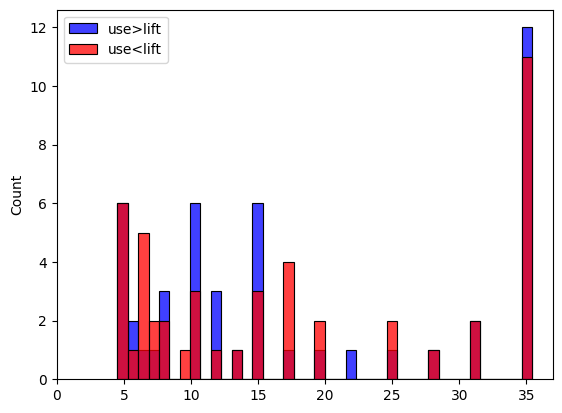

In [322]:
ax = sns.histplot(eval_SR_peaks, color='b', label='use>lift', bins=40,)
ax = sns.histplot(eval_RS_peaks, color='r', label='use<lift', bins=40,)
ax.legend()
ax.set(
    xticks=np.arange(0, 40, 5)
);

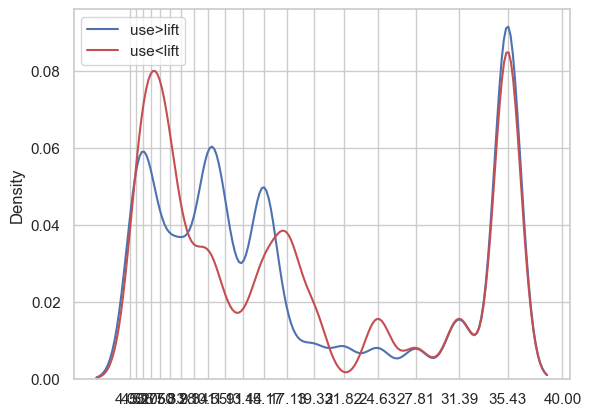

In [354]:
sns.set(style='whitegrid')
ax = sns.kdeplot(eval_SR_peaks, color='b', label='use>lift',bw_adjust=0.2)
ax = sns.kdeplot(eval_RS_peaks, color='r', label='use<lift',bw_adjust=0.2)
ax.legend()
ax.set(
    xticks=freqs
);

In [312]:
freqs

array([ 4.        ,  4.51535157,  5.09709994,  5.75379955,  6.49510696,
        7.33192284,  8.27655232,  9.34288588, 10.54660359, 11.90540577,
       13.43927315, 15.17076076, 17.12532959, 19.33172095, 21.82237912,
       24.63392844, 27.80771185, 31.39039881, 35.43467162, 40.        ])

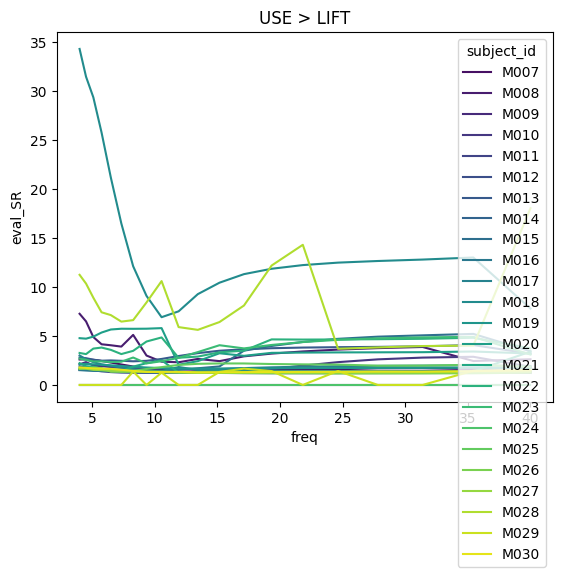

In [305]:
ax = sns.lineplot(data=GED_freq, y='eval_SR', x='freq', hue='subject_id', palette='viridis')
ax.set(
    title='USE > LIFT'
);

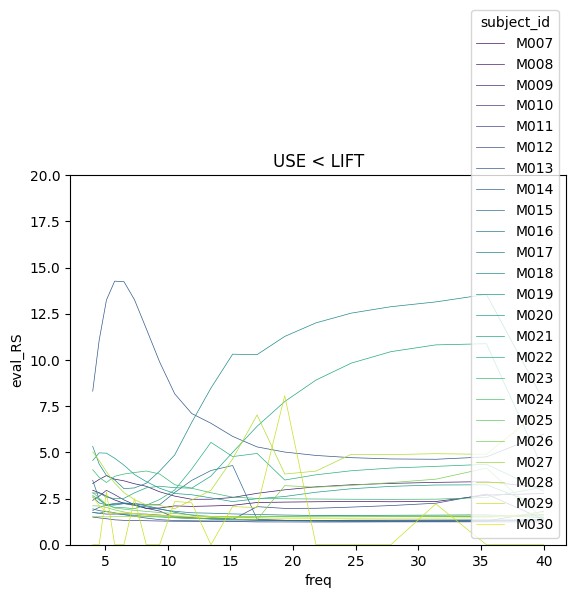

In [307]:
ax = sns.lineplot(data=GED_freq, y='eval_RS', x='freq', hue='subject_id', palette='viridis', lw=0.5)
ax.set(
    title='USE < LIFT',
    ylim=(0, 20)
);

In [342]:
GED_freq = GED_freq.query('eval_SR !=0 and eval_RS !=0')

In [365]:
def get_topo(s):
    if 'covS' in s.keys():
        return s['covS'] @ s['evec_SR']
    else:
        return s['covR'] @ s['evec_RS']
GED_freq.loc[:, 'topo_SR'] = GED_freq[['covS', 'evec_SR']].apply(lambda s: get_topo(s), axis=1)
GED_freq.loc[:, 'topo_RS'] = GED_freq[['covR', 'evec_RS']].apply(lambda s: get_topo(s), axis=1)


In [372]:
GED_freq.loc[0, 'topo_SR'].shape


(63,)

In [376]:
topo_SR = (
    GED_freq
    .groupby(['freq'], as_index=False)
    .topo_SR
    .apply(lambda x: np.mean(np.stack(x.T).T, axis=1))
)

In [379]:
topo_SR

,freq,topo_SR
0,4.000000,"[161013.0536047026, 59994.05813032518, 233254...."
1,4.515352,"[-415017.1732515852, -218152.68377774183, -276..."
2,5.097100,"[-493405.9184734943, -238973.20966804115, -371..."
3,5.753800,"[521474.02348753536, 281797.02430875285, 38621..."
4,6.495107,"[-216589.18453734514, -125829.14884179828, -14..."
5,7.331923,"[120408.74236114201, 65580.86681046031, 104503..."
6,8.276552,"[102272.89143869534, 60532.43346499103, 72033...."
7,9.342886,"[-44581.92025920412, -27888.23814433107, -2490..."
8,10.546604,"[934.8381602099737, 2021.545300029153, -3814.1..."
9,11.905406,"[-23529.848318986642, -14413.130659208728, -27..."


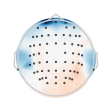

In [383]:
mne.viz.plot_topomap(topo_SR.loc[4, 'topo_SR'], epochs.info,
                            # cmap='vlag', 
                            contours=0,
                     # axes=ax[0],
                                # show = False,
                                # vlim=(-10e5, 10e5)
                               );

In [236]:
comp1 = np.mean(g1.evec_SR @ epochs.get_data(), axis=0)
comp2 = np.mean(g2.evec_RS @ epochs.get_data(), axis=0)

C:\Users\akeshava\AppData\Local\Temp\ipykernel_1488\3532936483.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  comp1 = np.mean(g1.evec_SR @ epochs.get_data(), axis=0)
C:\Users\akeshava\AppData\Local\Temp\ipykernel_1488\3532936483.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  comp2 = np.mean(g2.evec_RS @ epochs.get_data(), axis=0)


In [237]:
(g1.evec_SR @ epochs.get_data()).shape

C:\Users\akeshava\AppData\Local\Temp\ipykernel_1488\3531035579.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  (g1.evec_SR @ epochs.get_data()).shape


(96, 1434)

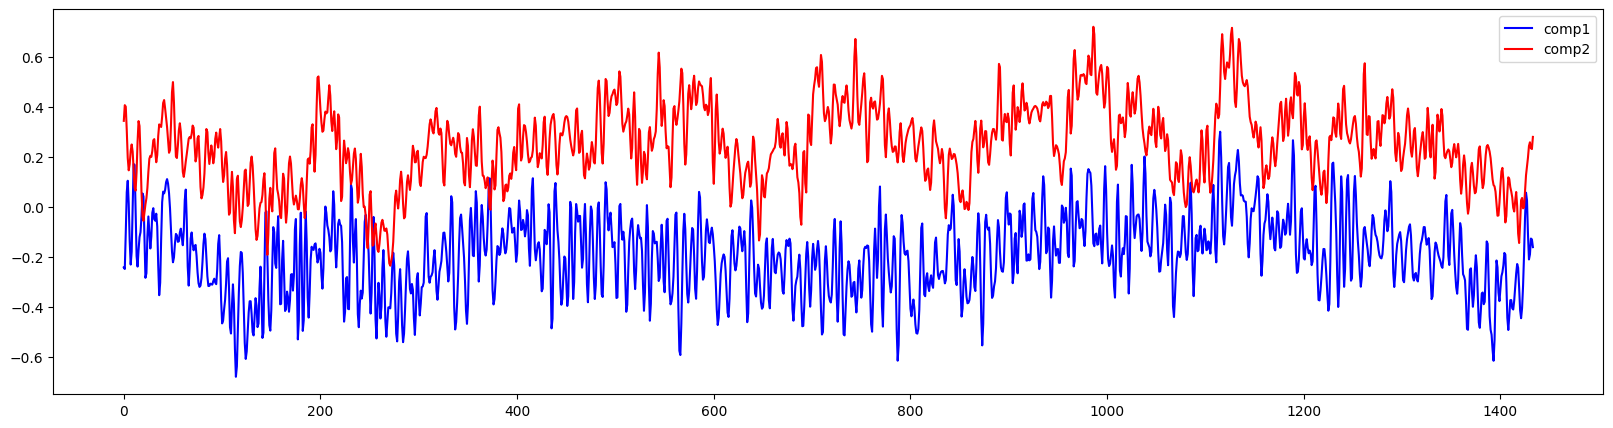

In [238]:
_, ax = plt.subplots(1, 1, figsize=(20, 5))

ax = sns.lineplot(comp1, label='comp1', ax=ax, color='b')
ax = sns.lineplot(comp2, label='comp2', ax=ax, color='r')

In [239]:
freqs = np.logspace(*np.log10([4, 40]), 2)
t=np.arange(-0.1, 3.1, 0.1)

t1, f1, Z1 = scipy.signal.stft(comp1, fs = 512, noverlap = 200, nperseg = 256)
t2, f2, Z2 = scipy.signal.stft(comp2, fs = 512, noverlap = 200, nperseg = 256)

Z1 = 20*np.log10(np.abs(Z1)) 
Z2 = 20*np.log10(np.abs(Z2)) 

In [212]:
print(Z1.min(), Z1.max())

-180.17560593540378 -8.590783188457397


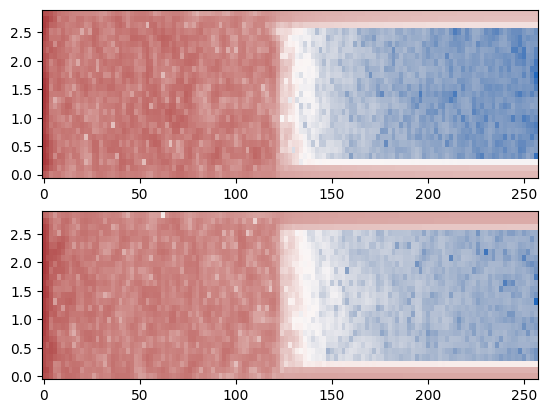

In [240]:
_, ax = plt.subplots(2, 1)

ax[0].pcolormesh(t1, f2, Z1.T, cmap='vlag')
ax[1].pcolormesh(t2, f2, Z2.T, cmap='vlag')

In [6]:
# freqs = [np.array([f, f+2]) for f in range(4, 40, 2)]
freqs = np.logspace(*np.log10([4, 40]), 20)
cycles = 2 * np.sqrt(np.logspace(np.log10(4), np.log10(10), freqs.shape[0]) / (2 * np.pi * freqs)) 
# cycles = 2 * ( (logspace(log10(4), log10(10), num_frex))./(2*pi*frex_lowres) ).^2;


ep = f'{PROCESSED_PATH}/M006/epoched/all_trials_epo.fif'
epochs = mne.read_epochs(ep, verbose=False)
tmpdf = {'subject_id':[], 'freq':[], 'evec_SR':[], 'eval_SR':[], 'evec_RS':[], 'eval_RS':[]}
# for fs in freqs:
filt_epo = tfr_morlet(epochs, freqs=freqs, n_cycles=cycles, return_itc=False, average=True)
# S = filt_epo['use'].data.mean(axis=2)
# R = filt_epo['lift'].data.mean(axis=2)

# print(S.shape)
    # calculate covariance matrix
    # covS = covmat(S.real)
    # covR = covmat(R.real)
    # # remove outlier covmats and average
    # covS = remove_outliers(covS)
    # covR = remove_outliers(covR)
    # # do GED: S>R
    # print(covS.shape, covR.shape)
    # evec1, eval1 = ged(covS, covR)
    # # do GED: S<R
    # evec2, eval2 = ged(covR, covS)

In [114]:
freqs = np.logspace(*np.log10([4, 40]), 20)
power_lift = tfr_morlet(epochs['lift'], freqs=freqs, n_cycles=freqs/2, return_itc=False, average=True)
# filt_epo.get_data().shape
# S = filt_epo['use'].data.me
# R = filt_epo['lift'].data.mean(axis=2)an(axis=2)
# sns.heatmap(R.mean(axis=0), cmap='Reds')
# filt_epo.plot_topo(dB=True, mode="logratio", title="Average power")

In [120]:
freqs = np.arange(4, 40, 2)
power_use = tfr_morlet(epochs['use'], freqs=freqs, n_cycles=freqs/2, return_itc=False, average=True)
# filt_epo.get_data().shape
# S = filt_epo['use'].data.me
# R = filt_epo['lift'].data.mean(axis=2)an(axis=2)
# sns.heatmap(R.mean(axis=0), cmap='Reds')
# filt_epo.plot_topo(dB=True, mode="logratio", title="Average power")

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


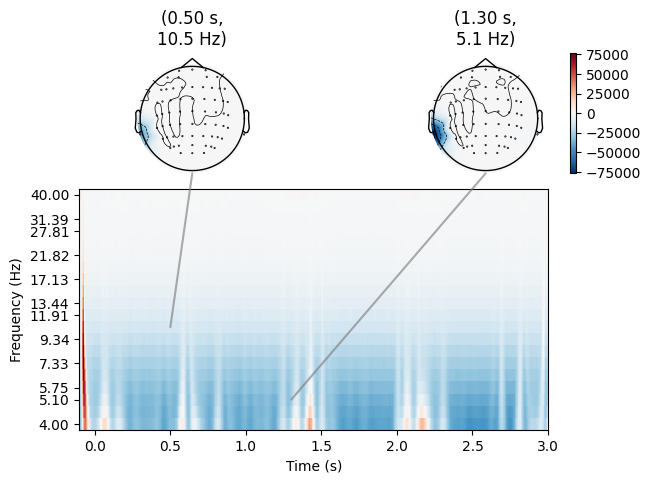

In [7]:
filt_epo.plot_joint(
    baseline=(-0.1, 0), mode="mean", tmin=-0.1, tmax=3, timefreqs=[(0.5, 10), (1.3, 5)]
);

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


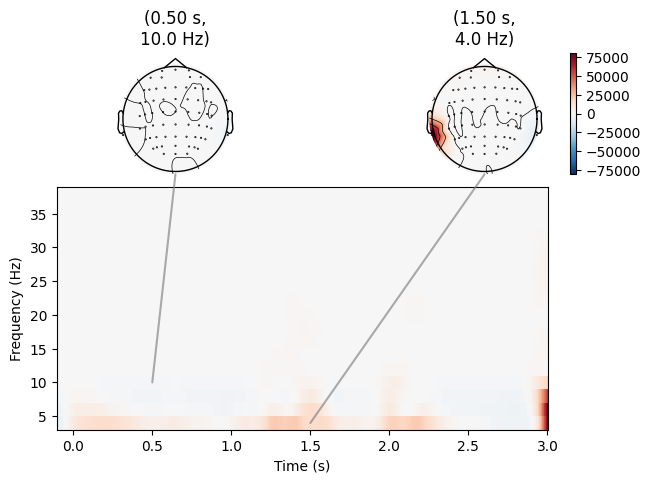

In [121]:
power_use.plot_joint(
    baseline=(-0.1, 0), mode="mean", tmin=-0.1, tmax=3, timefreqs=[(0.5, 10), (1.5, 5)]
);

<Axes: >

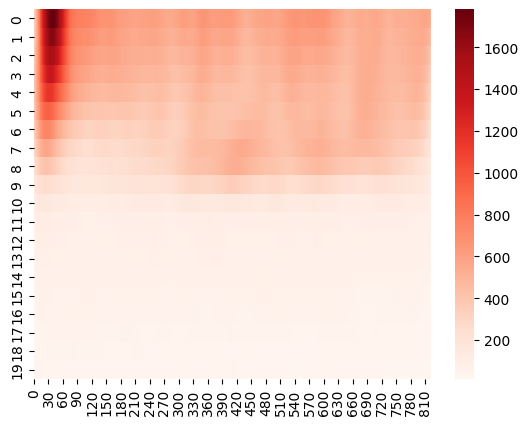